In [1]:
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [2]:
data_1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Regular_tweets1.csv")
data_2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sarcasm_tweets.csv")
data =  pd.concat([data_1, data_2])
data.head()

,date_time,tweet,spl_char1,spl_char2,is_sarcastic
0,14-04-2021 23:24,b'@kennygilmour It will become a #Regular spin...,b'RMeldrum1',b'Scotland',0
1,08-04-2021 16:34,b'BOSS #newlook \xf0\x9f\x98\x8d\xf0\x9f\x98\x...,b'ImwithVijayEsh1',b'',0
2,08-04-2021 08:33,b'Viking Grumpa like a regular grandpa only gr...,b'BeuteeS',"b'Brooklyn, US'",0
3,08-04-2021 07:05,b'All good things come in threes. The textures...,b'RAprahamian',b'Alsace',0
4,08-04-2021 06:40,b'Felt that moment \xf0\x9f\x98\x8d\nTag your ...,b'HappyWorldGoal1',b'New Delhi',0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2545 entries, 0 to 1738
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date_time     2545 non-null   object
 1   tweet         2545 non-null   object
 2   spl_char1     2545 non-null   object
 3   spl_char2     2544 non-null   object
 4   is_sarcastic  2545 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 119.3+ KB


In [4]:
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
def clean_text(df):
    all_reviews = list()
    lines = df["tweet"].values.tolist()
    for text in lines:
        text = text.lower()
        
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        
        emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text = emoji.sub(r'', text)
        
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"that's", "that is", text)        
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text) 
        text = re.sub(r"\'ll", " will", text)  
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"have't", "have not", text)

        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
        tokens = word_tokenize(text)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
#         stop_words = set(stopwords.words("english"))
#         stop_words.discard("not")
#         words = [w for w in words if not w in stop_words]
        words = ' '.join(words)
        all_reviews.append(words)
    return all_reviews

all_reviews = clean_text(data)
all_reviews[0:100]

['bkennygilmour it will become a regular spin',
 'bboss newlook n n n nfollow for regular updates of sir exclusively',
 'bviking grumpa like a regular grandpa only grumpier shirt hoodiensee more beutee',
 'ball good things come in threes the textures of olin give you maximum choice in tactilitynnolinpaper',
 'bfelt that moment your partner hi hello hey talks sillytalks finaltouchup',
 'regular computer teacher vacancynno job no',
 'bif you no go talk sense then u no get the features herrrr sarkodie now listening to regular ft mugeez',
 'bstaringispolite so excited gon na poop everyday leading up to this regular',
 'bwhen you look at the kardashians you see how vain they are amp have been from the beginning but they talk',
 'bhappy nationalbeerday often imitated but never duplicated the only the best the original',
 'bthank you so much lord nregular',
 'bnew product alert vegan seamossgummies regular cbd purplehondo honduras highlyedibles',
 'b wouldo you hear the bell tollnncoming soon

In [7]:
print(data)

             date_time  ... is_sarcastic
0     14-04-2021 23:24  ...            0
1     08-04-2021 16:34  ...            0
2     08-04-2021 08:33  ...            0
3     08-04-2021 07:05  ...            0
4     08-04-2021 06:40  ...            0
...                ...  ...          ...
1734  19-04-2021 15:01  ...            1
1735  19-04-2021 15:01  ...            1
1736  19-04-2021 14:52  ...            1
1737  19-04-2021 14:50  ...            1
1738  19-04-2021 14:50  ...            1

[2545 rows x 5 columns]


In [8]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def CleanTokenize(df):
    head_lines = list()
    lines = df["tweet"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

head_lines = CleanTokenize(data)
head_lines[0:10]

[['bkennygilmour', 'become', 'regular', 'spin'],
 ['bboss',
  'newlook',
  'n',
  'n',
  'n',
  'nfollow',
  'regular',
  'updates',
  'sir',
  'exclusively'],
 ['bviking',
  'grumpa',
  'like',
  'regular',
  'grandpa',
  'grumpier',
  'shirt',
  'hoodiensee',
  'beutee'],
 ['ball',
  'good',
  'things',
  'come',
  'threes',
  'textures',
  'olin',
  'give',
  'maximum',
  'choice',
  'tactilitynnolinpaper'],
 ['bfelt',
  'moment',
  'partner',
  'hi',
  'hello',
  'hey',
  'talks',
  'sillytalks',
  'finaltouchup'],
 ['regular', 'computer', 'teacher', 'vacancynno', 'job'],
 ['bif',
  'go',
  'talk',
  'sense',
  'u',
  'get',
  'features',
  'herrrr',
  'listening',
  'regular',
  'ft'],
 ['bstaringispolite',
  'excited',
  'gon',
  'na',
  'poop',
  'everyday',
  'leading',
  'regular'],
 ['bwhen', 'look', 'kardashians', 'see', 'vain', 'amp', 'beginning', 'talk'],
 ['bhappy',
  'nationalbeerday',
  'often',
  'imitated',
  'never',
  'duplicated',
  'best',
  'original']]

(-0.5, 999.5, 499.5, -0.5)

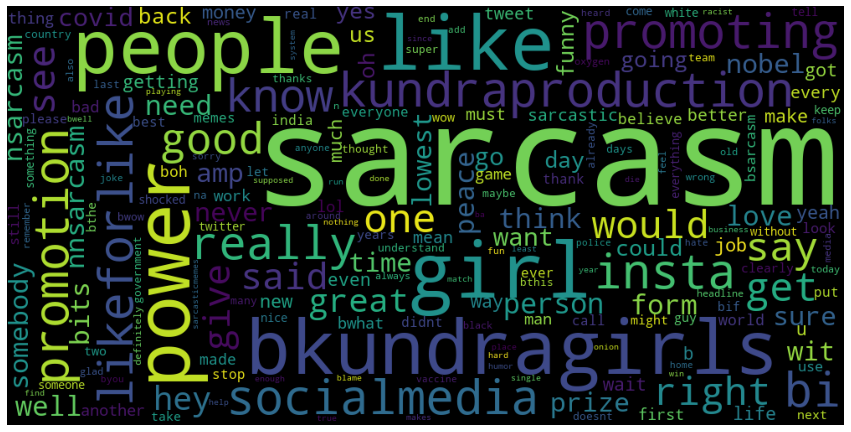

In [11]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = data.loc[data['is_sarcastic'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

In [12]:
validation_split = 0.2
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(head_lines)
sequences = tokenizer_obj.texts_to_sequences(head_lines)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['is_sarcastic'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

unique tokens -  6090
vocab size - 6091


In [13]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (2036, 25)
Shape of y_train: (2036,)
Shape of X_test_pad: (509, 25)
Shape of y_test: (509,)


In [14]:
embeddings_index = {}
embedding_dim = 100
GLOVE_DIR = "/content/drive/MyDrive/Colab Notebooks"
f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.100d.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [15]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
c = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        c+=1
        embedding_matrix[i] = embedding_vector
print('Embedding vector ',+c)

Embedding vector  4386


In [16]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

RNN Network

In [17]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.25))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

print('Summary of the built model...')
print(model.summary())

Summary of the built model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 100)           609100    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 651,405
Trainable params: 42,305
Non-trainable params: 609,100
_________________________________________________________________
None


In [18]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=50, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/50
64/64 - 30s - loss: 0.4067 - acc: 0.8325 - val_loss: 0.2276 - val_acc: 0.9116
Epoch 2/50
64/64 - 2s - loss: 0.1868 - acc: 0.9317 - val_loss: 0.1019 - val_acc: 0.9745
Epoch 3/50
64/64 - 2s - loss: 0.1216 - acc: 0.9533 - val_loss: 0.0783 - val_acc: 0.9823
Epoch 4/50
64/64 - 2s - loss: 0.0832 - acc: 0.9725 - val_loss: 0.0789 - val_acc: 0.9764
Epoch 5/50
64/64 - 2s - loss: 0.0628 - acc: 0.9769 - val_loss: 0.0614 - val_acc: 0.9843
Epoch 6/50
64/64 - 2s - loss: 0.0560 - acc: 0.9789 - val_loss: 0.0568 - val_acc: 0.9843
Epoch 7/50
64/64 - 2s - loss: 0.0444 - acc: 0.9843 - val_loss: 0.0846 - val_acc: 0.9843
Epoch 8/50
64/64 - 2s - loss: 0.0574 - acc: 0.9779 - val_loss: 0.0723 - val_acc: 0.9823
Epoch 9/50
64/64 - 2s - loss: 0.0439 - acc: 0.9818 - val_loss: 0.0830 - val_acc: 0.9784
Epoch 10/50
64/64 - 2s - loss: 0.0325 - acc: 0.9867 - val_loss: 0.0759 - val_acc: 0.9823
Epoch 11/50
64/64 - 2s - loss: 0.0234 - acc: 0.9912 - val_loss: 0.0928 - val_acc: 0.9784
Epoch 12/50
64/64 - 2s - loss

Validation loss and accuracy of RNN

In [19]:
scores_rnn_train = model.evaluate(X_test_pad, y_test, verbose=2)
print("validation_loss: %.2f%%" % (scores_rnn_train[0]*100))
print("validation_Accuracy: %.2f%%" % (scores_rnn_train[1]*100))

16/16 - 0s - loss: 0.0848 - acc: 0.9823
validation_loss: 8.48%
validation_Accuracy: 98.23%


Training loss and accuracy of CNN

In [20]:
scores_rnn_val = model.evaluate(X_train_pad, y_train, verbose=2)
print("training_loss: %.2f%%" % (scores_rnn_val[0]*100))
print("training_Accuracy: %.2f%%" % (scores_rnn_val[1]*100))

64/64 - 0s - loss: 0.0122 - acc: 0.9926
training_loss: 1.22%
training_Accuracy: 99.26%


Performance Metrics of RNN

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [22]:
yhat_classes = model.predict_classes(X_train_pad, verbose=2)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


64/64 - 1s


In [23]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.992633
Precision: 1.000000
Recall: 0.988938
F1 score: 0.994438


In [24]:
matrix = confusion_matrix(y_train, yhat_classes)
print(matrix)


[[ 680    0]
 [  15 1341]]


In [25]:
yhat_classes = model.predict_classes(X_test_pad, verbose=2)

16/16 - 0s


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [26]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.982318
Precision: 0.984802
Recall: 0.987805
F1 score: 0.986301


In [27]:
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

[[176   5]
 [  4 324]]


Plots of RNN

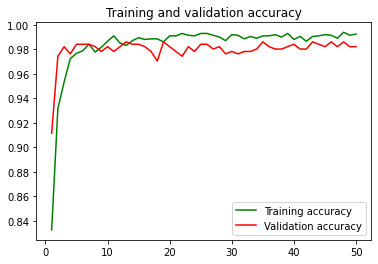

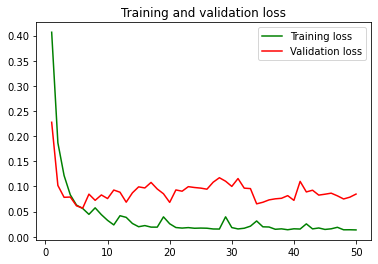

In [28]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Testing of RNN

In [29]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"tweet":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."

In [30]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")

"It's a sarcasm!"

In [31]:
predict_sarcasm("b'All good things come in threes. The textures of Olin give you maximum choice in tactility.\n\n#olinpaper #designpaper\xe2\x80\xa6 https://t.co/gOhPVc5CCe'")

"It's not a sarcasm."

In [32]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.manifold import TSNE

CNN

In [33]:
model_glove = Sequential()
model_glove.add(Embedding(vocab_size , 100, input_length=50, weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(0.2))
model_glove.add(Conv1D(64, 5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(LSTM(100))
model_glove.add(Dense(1, activation='sigmoid'))
model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print('Summary of the built model...')
print(model_glove.summary())

Summary of the built model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           609100    
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 707,265
Trainable params: 98,165
Non-trainable params: 609,100
_____________

In [34]:
history = model_glove.fit(X_train_pad, y_train, batch_size=32, epochs=50, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/50
64/64 - 6s - loss: 0.3388 - accuracy: 0.8394 - val_loss: 0.1305 - val_accuracy: 0.9568
Epoch 2/50
64/64 - 1s - loss: 0.1014 - accuracy: 0.9592 - val_loss: 0.0563 - val_accuracy: 0.9843
Epoch 3/50
64/64 - 1s - loss: 0.0536 - accuracy: 0.9843 - val_loss: 0.0503 - val_accuracy: 0.9862
Epoch 4/50
64/64 - 1s - loss: 0.0407 - accuracy: 0.9838 - val_loss: 0.0448 - val_accuracy: 0.9843
Epoch 5/50
64/64 - 1s - loss: 0.0286 - accuracy: 0.9897 - val_loss: 0.0774 - val_accuracy: 0.9823
Epoch 6/50
64/64 - 1s - loss: 0.0294 - accuracy: 0.9887 - val_loss: 0.0697 - val_accuracy: 0.9804
Epoch 7/50
64/64 - 1s - loss: 0.0341 - accuracy: 0.9862 - val_loss: 0.0726 - val_accuracy: 0.9764
Epoch 8/50
64/64 - 1s - loss: 0.0309 - accuracy: 0.9872 - val_loss: 0.0694 - val_accuracy: 0.9804
Epoch 9/50
64/64 - 1s - loss: 0.0201 - accuracy: 0.9902 - val_loss: 0.0691 - val_accuracy: 0.9764
Epoch 10/50
64/64 - 1s - loss: 0.0239 - accuracy: 0.9887 - val_loss: 0.0672 - val_accuracy: 0.9843
Epoch 11/50
64/64 -

Validation loss and Accuracy

In [35]:
scores_cnn_train = model_glove.evaluate(X_test_pad, y_test, verbose=2)
print("valiadtion_loss: %.2f%%" % (scores_cnn_train[0]*100))
print("validation_Accuracy: %.2f%%" % (scores_cnn_train[1]*100))

16/16 - 0s - loss: 0.1033 - accuracy: 0.9843
valiadtion_loss: 10.33%
validation_Accuracy: 98.43%


Training loss and Accuracy

In [36]:
scores_cnn_val = model_glove.evaluate(X_train_pad, y_train, verbose=2)
print("training_loss: %.2f%%" % (scores_cnn_val[0]*100))
print("training_Accuracy: %.2f%%" % (scores_cnn_val[1]*100))

64/64 - 0s - loss: 0.0117 - accuracy: 0.9926
training_loss: 1.17%
training_Accuracy: 99.26%


Traning performence metrics

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Performance Metrics

In [38]:
yhat_classes = model_glove.predict_classes(X_train_pad, verbose=2)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



64/64 - 1s


In [39]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_train, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_train, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_train, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_train, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.992633
Precision: 0.989774
Recall: 0.999263
F1 score: 0.994495


In [40]:
matrix = confusion_matrix(y_train, yhat_classes)
print(matrix)

[[ 666   14]
 [   1 1355]]


Validation Performance Metrics

In [41]:
yhat_classes = model_glove.predict_classes(X_test_pad, verbose=2)

16/16 - 0s


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning:

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).



In [42]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

Accuracy: 0.984283
Precision: 0.979042
Recall: 0.996951
F1 score: 0.987915


In [43]:
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

[[174   7]
 [  1 327]]


In [ ]:
Plotting of CNN 

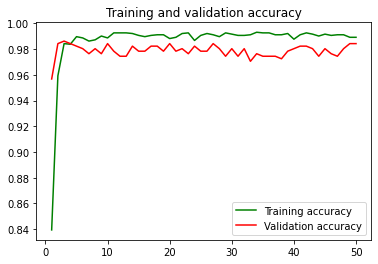

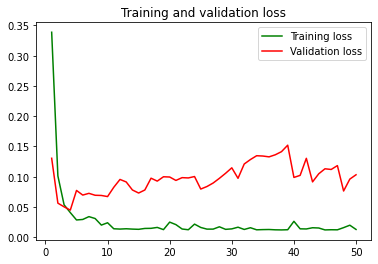

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Testing of CNN 

In [45]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"tweet":[s]})
    test_lines = CleanTokenize(x_final)
    test_sequences = tokenizer_obj.texts_to_sequences(test_lines)
    test_review_pad = pad_sequences(test_sequences, maxlen=max_length, padding='post')
    pred = model_glove.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: return "It's a sarcasm!" 
    else: return "It's not a sarcasm."

In [46]:
predict_sarcasm("I was depressed. He asked me to be happy. I am not depressed anymore.")

"It's a sarcasm!"

In [47]:
predict_sarcasm("b'All good things come in threes. The textures of Olin give you maximum choice in tactility.\n\n#olinpaper #designpaper\xe2\x80\xa6 https://t.co/gOhPVc5CCe'")

"It's not a sarcasm."

COMPARISON

In [48]:
if (scores_rnn_train[1] > scores_cnn_train[1]):
     st = "RNN IS BETTER COMPARED TO CNN by comparing training accuracy"
     print(st)

else:
     st="CNN IS BETTEER COMPARED TO RNN by comparing training accuracy"
     print(st)

CNN IS BETTEER COMPARED TO RNN by comparing training accuracy


In [49]:
if (scores_rnn_val[1] > scores_cnn_val[1]):
     st = "RNN IS BETTER COMPARED TO CNN by comparing validation accuracy"
     print(st)

else:
     st="CNN IS BETTEER COMPARED TO RNN by comparing validation accuracy"
     print(st)

CNN IS BETTEER COMPARED TO RNN by comparing validation accuracy


In [50]:
if (scores_rnn_train[0] < scores_cnn_train[0]):
     st = "RNN IS BETTER COMPARED TO CNN by comparing training loss"
     print(st)

else:
     st="CNN IS BETTEER COMPARED TO RNN by comparing training loss"
     print(st)

RNN IS BETTER COMPARED TO CNN by comparing training loss


In [51]:
if (scores_rnn_val[0] < scores_cnn_val[0]):
     st = "RNN IS BETTER COMPARED TO CNN by comparing validation loss"
     print(st)

else:
     st="CNN IS BETTEER COMPARED TO RNN by comparing validation loss"
     print(st)

CNN IS BETTEER COMPARED TO RNN by comparing validation loss
